# Bank Churn Prediction - Neural Networks

## Background

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

## Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

## Import Libraries

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import keras
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
from tensorflow.keras import optimizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
df = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/bank.csv')

In [83]:
df.shape

(10000, 14)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Data Cleaning



> Converting Object data types to categorical



In [85]:
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature])# Replace strings with an integer
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#Univariate Analysis

In [86]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64




> Removing RowNumber, Surname an CustomerID as we dont need those in the dataset



In [87]:
df_sub = df.drop(['RowNumber', 'Surname', 'CustomerId', 'IsActiveMember'], axis= 1)

In [88]:
df_sub.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [89]:
df_sub.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,113931.57,1
3,699,France,Female,39,1,0.00,2,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,79084.10,0


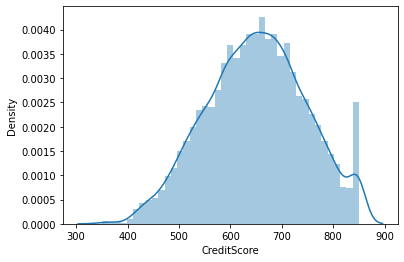

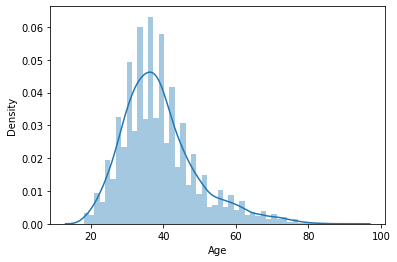

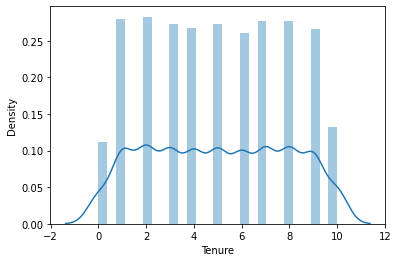

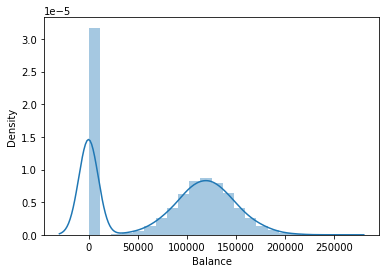

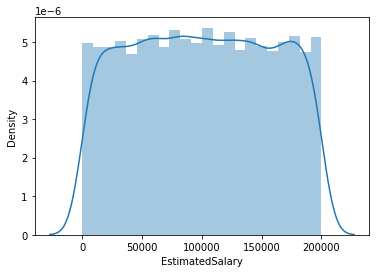

In [13]:
for i in list(['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']):  
    sns.distplot(df[i])
    plt.show()

## Conclusion Univariate Analysis

*   Their are no null values in the dataset
*   CustomerID, Row Number, Surname and IsActiveMember were removed from the dataset as they didnt seem like relevant features
*   Balance has a lot of zero and has some outliers
* Credit Score has a spike at 850
   





# Bivariate Analysis

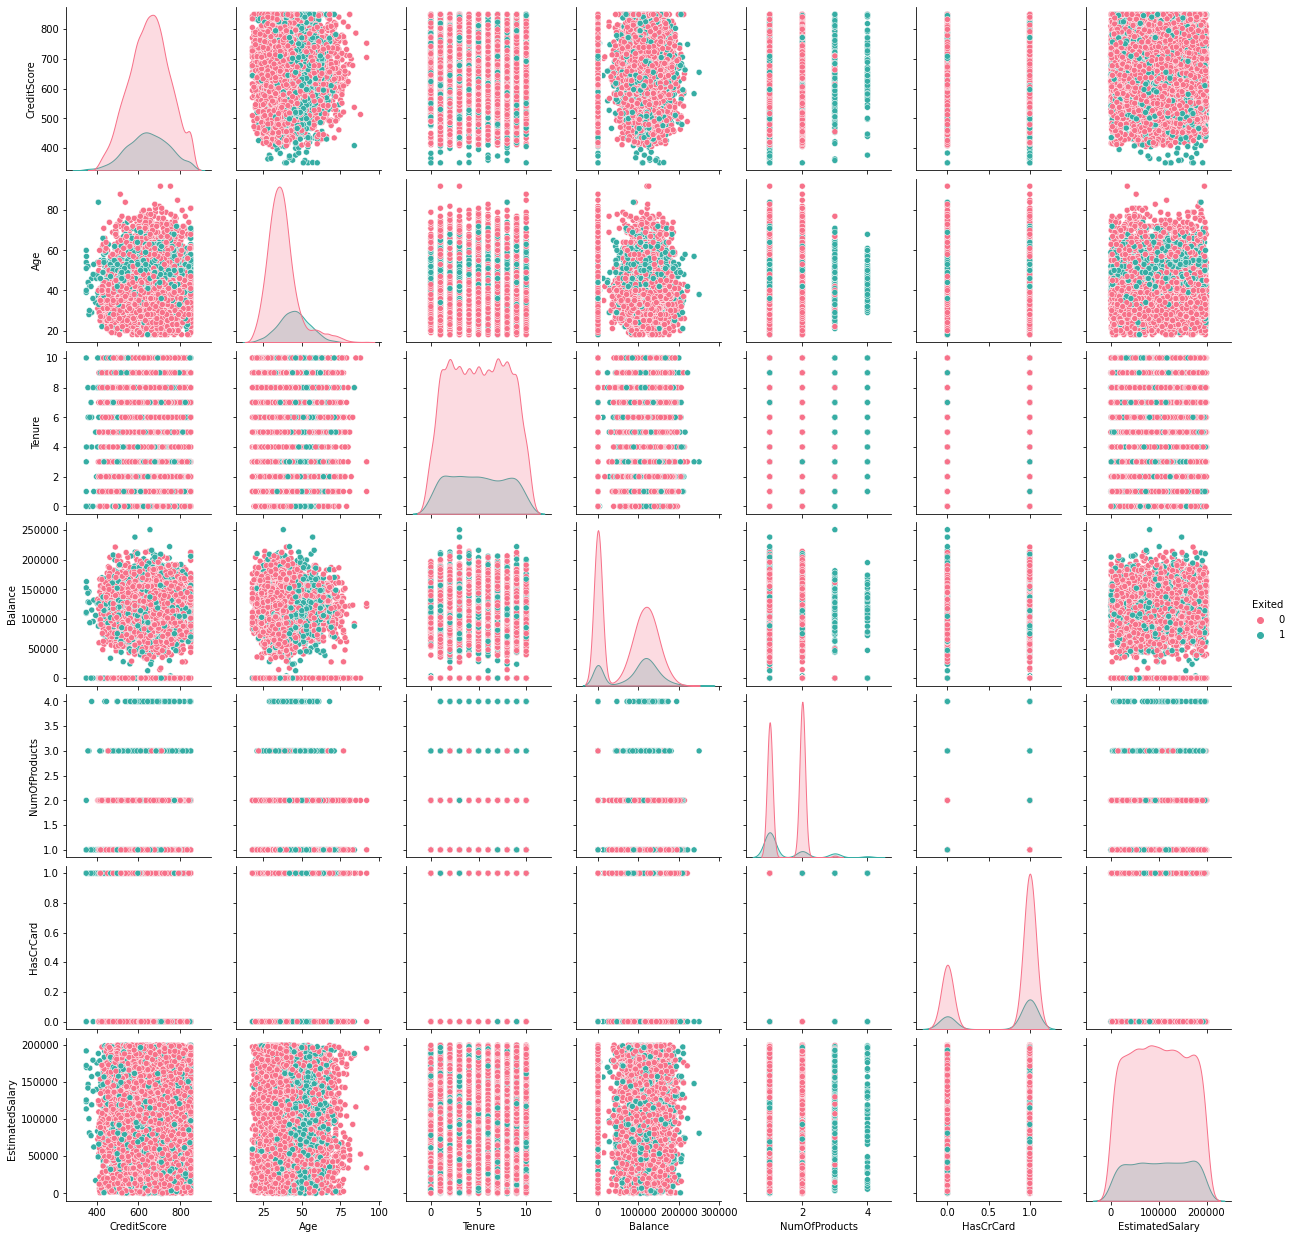

In [90]:
sns.pairplot(df_sub, hue="Exited", palette="husl")

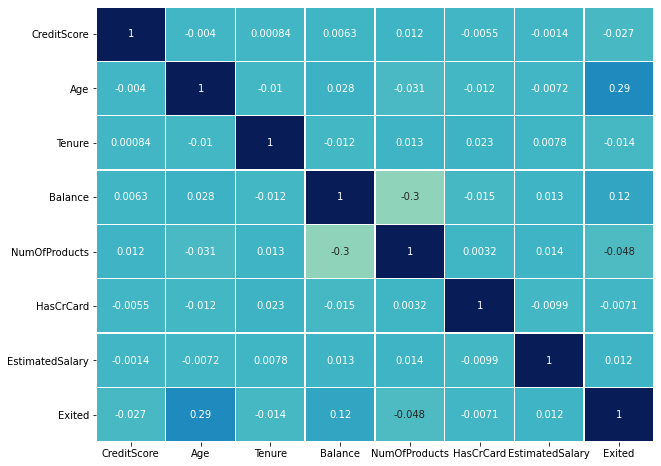

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(df_sub.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

In [92]:
df_sub.groupby(["Exited"]).mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary
Exited,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,101465.677531


In [93]:
df_sub.groupby(["Exited"]).count()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary
Exited,,,,,,,,,
0,7963,7963,7963,7963,7963,7963,7963,7963,7963
1,2037,2037,2037,2037,2037,2037,2037,2037,2037


In [94]:
df_sub.groupby(["Exited"]).median()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary
Exited,,,,,,,
0,653,36,5,92072.68,2,1,99645.04
1,646,45,5,109349.29,1,1,102460.84


In [95]:
pd.crosstab(df['Gender'],df['Exited'],normalize='index')

Exited,0,1
Gender,,
Female,0.749285,0.250715
Male,0.835441,0.164559


In [97]:
pd.crosstab(df['Geography'],df['Exited'],normalize='index')

Exited,0,1
Geography,,
France,0.838452,0.161548
Germany,0.675568,0.324432
Spain,0.833266,0.166734


## Conclusion Bivariate Analysis



1.   Age is positively correlated to churn. Older customers are more likely to leave
2.  Customers with less than two products have a higher churn rate
3. Germany has a higher churn rate
4. More women leave the bank 



# Pre Processing of Data

### Label Encoding  For Geography

In [98]:
le = preprocessing.LabelEncoder()
le.fit(["France", "Germany", "Spain"])
LabelEncoder()
list(le.classes_)
["France", "Germany", "Spain"]
df['Geo_Encoded']= le.transform(df["Geography"])


In [99]:
pd.crosstab(df['Geo_Encoded'],df['Exited'],normalize='index')

Exited,0,1
Geo_Encoded,,
0,0.838452,0.161548
1,0.675568,0.324432
2,0.833266,0.166734


In [100]:
df= pd.get_dummies(df,columns= ['Geo_Encoded'])

In [101]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_Encoded_0,Geo_Encoded_1,Geo_Encoded_2
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


### Label Encoding for Gender

In [102]:
le = preprocessing.LabelEncoder()
le.fit(["Female", "Male"])
LabelEncoder()
list(le.classes_)
["Female", "Male"]
df['Gender_Encoded']= le.transform(df["Gender"])


In [103]:
pd.crosstab(df['Gender_Encoded'],df['Exited'],normalize='index')

Exited,0,1
Gender_Encoded,,
0,0.749285,0.250715
1,0.835441,0.164559


In [104]:
df= pd.get_dummies(df, columns=['Gender_Encoded'])

In [105]:
 df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_Encoded_0,Geo_Encoded_1,Geo_Encoded_2,Gender_Encoded_0,Gender_Encoded_1
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


### Defining X and y data sets

In [121]:
 X_data = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geo_Encoded_0', 'Geo_Encoded_1', 'Geo_Encoded_2','Gender_Encoded_0', 'Gender_Encoded_1']]

In [122]:
X_data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,EstimatedSalary,Geo_Encoded_0,Geo_Encoded_1,Geo_Encoded_2,Gender_Encoded_0,Gender_Encoded_1
0,619,42,2,0.00,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,96270.64,1,0,0,0,1
9996,516,35,10,57369.61,1,1,101699.77,1,0,0,0,1
9997,709,36,7,0.00,1,0,42085.58,1,0,0,1,0
9998,772,42,3,75075.31,2,1,92888.52,0,1,0,0,1


In [123]:
y_data = df['Exited']

In [124]:
y_data

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

### Splitting Training and Test Dataset

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

### Normalizing using Standard Sacler

In [126]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [127]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 12)
(2000, 12)
(8000,)
(2000,)


# Model Development




In [130]:
classifier = Sequential()
classifier.add(Dense(24, input_shape = (12,), activation = 'relu'))
classifier.add(Dense(16, activation = 'relu'))
classifier.add(Dense(8, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
sgd = optimizers.Adam(lr = 0.01)
classifier.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics= 'accuracy')

In [131]:
classifier.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 24)                312       
_________________________________________________________________
dense_42 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 9         
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


# Model Training



In [134]:
history = classifier.fit(X_train, y_train.values, batch_size = 100, epochs = 10, verbose = 1, validation_split= 0.2)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.info)

Epoch 1/10
64/64 [==============================] - 0s 4ms/step - loss: 0.4553 - accuracy: 0.8008 - val_loss: 0.4401 - val_accuracy: 0.8006
Epoch 2/10
64/64 [==============================] - 0s 2ms/step - loss: 0.3819 - accuracy: 0.8356 - val_loss: 0.3913 - val_accuracy: 0.8288
Epoch 3/10
64/64 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.8497 - val_loss: 0.3889 - val_accuracy: 0.8313
Epoch 4/10
64/64 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.8525 - val_loss: 0.3971 - val_accuracy: 0.8363
Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 0.3498 - accuracy: 0.8537 - val_loss: 0.3830 - val_accuracy: 0.8331
Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8534 - val_loss: 0.3783 - val_accuracy: 0.8425
Epoch 7/10
64/64 [==============================] - 0s 1ms/step - loss: 0.3449 - accuracy: 0.8541 - val_loss: 0.3843 - val_accuracy: 0.8363
Epoch 8/10
64/64 [==

In [135]:
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.348150,0.853437,0.378273,0.842500,5
6,0.344902,0.854062,0.384309,0.836250,6
7,0.341692,0.855000,0.380154,0.840625,7
8,0.343376,0.857500,0.377684,0.843750,8
9,0.339619,0.856875,0.380665,0.837500,9


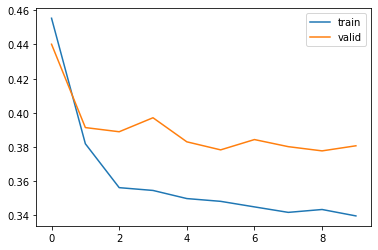

In [136]:
import matplotlib.pyplot as plt

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train", "valid"), loc = 0)

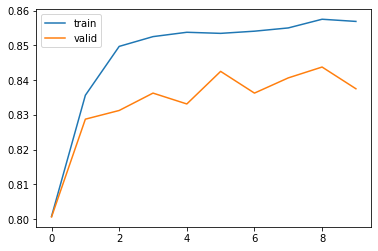

In [137]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train", "valid"), loc = 0)

## Conclusion 

This model seems to be Overfitting. As the accuracy on the validation set is 83.5% and that on the test 85.6%

## Model Evaluation


In [185]:
#Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [186]:
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [187]:
results = classifier.evaluate(X_test, y_test.values)

63/63 [==============================] - 0s 1ms/step - loss: 0.3742 - accuracy: 0.8385


In [188]:
y_test

1977    1
3880    0
52      0
2551    0
2246    0
       ..
9505    0
2836    0
1169    0
9929    0
8486    1
Name: Exited, Length: 2000, dtype: int64

In [192]:
print(results)    

[0.3742213845252991, 0.8385000228881836]


### Confusion Matrix

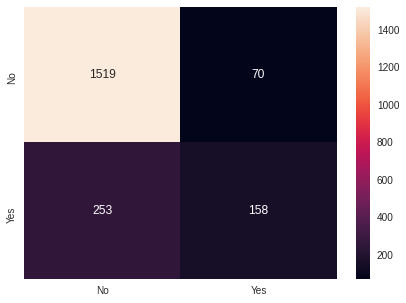

In [197]:
cm= metrics.confusion_matrix(y_test, y_pred,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [194]:
Y_pred_cls = classifier.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(classifier.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Accuracy_score: ' + str(accuracy_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))

63/63 [==============================] - 0s 1ms/step - loss: 0.3742 - accuracy: 0.8385
Accuracy Model1 (Dropout): 0.8385000228881836
Recall_score: 0.3844282238442822
Accuracy_score: 0.8385
Precision_score: 0.6929824561403509
F-score: 0.4945226917057904


array([[1519,   70],
       [ 253,  158]])

# Model prediction with the threshold of 50%

In [203]:
#Threshold of 50%
threshold = 0.5
y_pred_results = classifier.predict(X_test)
y_pred_results[y_pred_results > threshold] = 1
y_pred_results[y_pred_results <= threshold] = 0
y_pred_results

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

# Model Tuning and Optimization

### Optimizer, Epochs and Batch Size

In [ ]:
def build_classifier(optimizer):
     classifier = Sequential()
     classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
     classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
     classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
     return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10, 20, 50, 100],'epochs': [50, 100], 'optimizer': ['adam', 'rmsprop']}

grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [62]:
best_parameters


{'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}

In [63]:
best_accuracy

0.851625

### Learning Rate and Momentum

In [71]:
from keras.optimizers import SGD
def build_classifier(learn_rate=0.01):
     classifier = Sequential()
     classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
     classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
     optimizer = SGD(lr=learn_rate)
     classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
     return classifier
classifier = KerasClassifier(build_fn = build_classifier, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
parameters = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator = classifier, param_grid = parameters, n_jobs= -1)
grid_result = grid.fit(X_train, y_train)
best_parameters = grid_result.best_params_
best_accuracy = grid_result.best_score_



In [72]:
best_parameters

{'learn_rate': 0.1}

### Dropout Regularization

In [212]:
def build_classifier(dropout_rate=0.0, weight_constraint=0):
     classifier = Sequential()
     classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))
     classifier.add(Dropout(dropout_rate))
     classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
     classifier.add(Dropout(dropout_rate))
     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
     classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
     return classifier
classifier = KerasClassifier(build_fn = build_classifier, epochs=10, batch_size=100, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3]
dropout_rate = [0.0, 0.1, 0.2, 0.3]

parameters = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator = classifier, param_grid = parameters, n_jobs= -1, cv=3)
grid_result = grid.fit(X_train, y_train)
best_parameters = grid_result.best_params_
best_accuracy = grid_result.best_score_

In [213]:
best_parameters

{'dropout_rate': 0.0, 'weight_constraint': 1}

# Final Model

In [252]:
classifier = Sequential()
classifier.add(Dense(24, input_shape = (12,), activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.2))
classifier.add(Dense(1, activation = 'sigmoid'))
sgd = optimizers.Adam(lr = 0.01)
classifier.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics= 'accuracy')

In [253]:
history = classifier.fit(X_train, y_train.values, batch_size = 25, epochs = 50, verbose = 1, validation_split= 0.2)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.info)

Epoch 1/50
256/256 [==============================] - 0s 2ms/step - loss: 0.4637 - accuracy: 0.7983 - val_loss: 0.4400 - val_accuracy: 0.8031
Epoch 2/50
256/256 [==============================] - 0s 1ms/step - loss: 0.4129 - accuracy: 0.8155 - val_loss: 0.4055 - val_accuracy: 0.8156
Epoch 3/50
256/256 [==============================] - 0s 1ms/step - loss: 0.4037 - accuracy: 0.8198 - val_loss: 0.3960 - val_accuracy: 0.8281
Epoch 4/50
256/256 [==============================] - 0s 1ms/step - loss: 0.3890 - accuracy: 0.8336 - val_loss: 0.3888 - val_accuracy: 0.8344
Epoch 5/50
256/256 [==============================] - 0s 1ms/step - loss: 0.3857 - accuracy: 0.8363 - val_loss: 0.3969 - val_accuracy: 0.8194
Epoch 6/50
256/256 [==============================] - 0s 1ms/step - loss: 0.3805 - accuracy: 0.8359 - val_loss: 0.3807 - val_accuracy: 0.8375
Epoch 7/50
256/256 [==============================] - 0s 1ms/step - loss: 0.3816 - accuracy: 0.8398 - val_loss: 0.3983 - val_accuracy: 0.8338
Epoch 

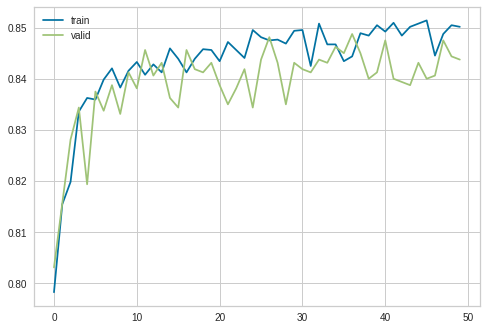

In [254]:
import matplotlib.pyplot as plt

plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train", "valid"), loc = 0)

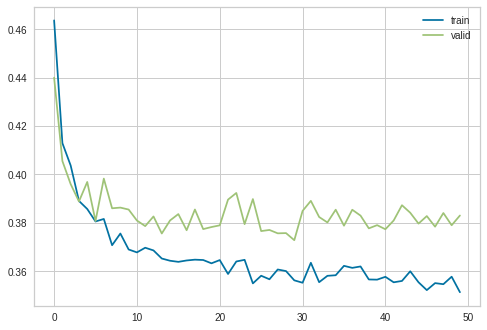

In [255]:
import matplotlib.pyplot as plt

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train", "valid"), loc = 0)

## Model Evaluation

In [257]:
results = classifier.evaluate(X_test, y_test.values)

63/63 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.8460


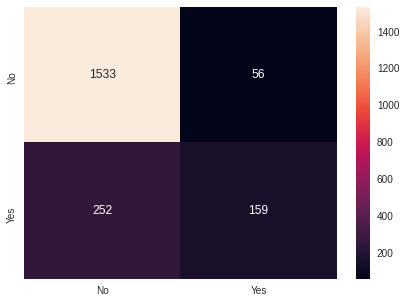

In [258]:
cm= metrics.confusion_matrix(y_test, y_pred,labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')

In [259]:
Y_pred_cls = classifier.predict_classes(X_test, batch_size=200, verbose=0)
print('Accuracy Model1 (Dropout): '+ str(classifier.evaluate(X_test,y_test.values)[1]))
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Accuracy_score: ' + str(accuracy_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls)))

63/63 [==============================] - 0s 1ms/step - loss: 0.3763 - accuracy: 0.8460
Accuracy Model1 (Dropout): 0.8460000157356262
Recall_score: 0.38686131386861317
Accuracy_score: 0.846
Precision_score: 0.7395348837209302
F-score: 0.5079872204472844


## Getting Actual Prediction Results

In [260]:
#Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [261]:
 new_data = df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'EstimatedSalary', 'Geo_Encoded_0', 'Geo_Encoded_1', 'Geo_Encoded_2','Gender_Encoded_0', 'Gender_Encoded_1']]

In [270]:
sc = StandardScaler()
new_data = sc.fit_transform(new_data)

In [294]:
pred = classifier.predict(new_data)
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0
pred

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [308]:
dfnew = pd.DataFrame(pred, columns=['pred'])

In [309]:
df_predict = pd.concat([df,dfnew], axis =1)

In [316]:
df_predict [['CustomerId', 'Exited', 'pred']]

,CustomerId,Exited,pred
0,15634602,1,1.0
1,15647311,0,1.0
2,15619304,1,1.0
3,15701354,0,0.0
4,15737888,0,0.0
...,...,...,...
9995,15606229,0,0.0
9996,15569892,0,0.0
9997,15584532,1,0.0
9998,15682355,1,0.0


## Conclusion

The final model is 85% accurate. Even after parameter tuning the reults did not change by a lot. The model is still slightly overfitting since the validation set has a higher loss.

The final models has the following parameters: 

Optimizer = Adam

Learning Rate = 0.01

Batch Size = 25 

Epoch= 50